In [1]:
import pandas as pd
import numpy as np
import scipy
import regression as reg

import netpixi
import graph_tool_extras as gte

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def from_vertices_net_to_dataframe(net):
    data = {}
    for v in net.vertices():
        for key, value in v.items():
            key = key.replace(' ', '_')
            if key not in data.keys():
                data[key] = []
            data[key].append(value)
    return pd.DataFrame(data)

def from_edges_net_to_dataframe(net):
    data = {}
    for e in net.edges():
        for key, value in e.items():
            key = key.replace(' ', '_')
            if key not in data.keys(): 
                data[key] = []
            data[key].append(value)
    return pd.DataFrame(data)

In [3]:
g = gte.load('./rede_metricas.net.gz')

In [4]:
data = from_vertices_net_to_dataframe(g)
data_edges = from_edges_net_to_dataframe(g)

In [5]:
data_edges\
    .loc[(data_edges['node1'] == 'Banana') | (data_edges['node2'] == 'Banana')]\
    .sort_values('purchases_per_user', ascending=False)\
    .head()

,node1,node2,purchased_together,user_purchased_together,purchases_per_user
167,Banana,Bars Peanut Butter,68,1,68.0
157,Banana,Ham & Swiss Sandwich,64,1,64.0
172,Banana,Plastic Squared Plates,58,1,58.0
155,Banana,Jet Fuel Dark Roast Whole Bean Coffee,42,1,42.0
414095,Vanilla Hazelnut Coffee,Banana,32,1,32.0


In [38]:
independente = data['clustering']
dependente = data['PRC']
controle = np.log(data['degree'])

data_hipotese = pd.DataFrame({
    'independente': independente, 
    'dependente': dependente, 
    'controle': controle
})

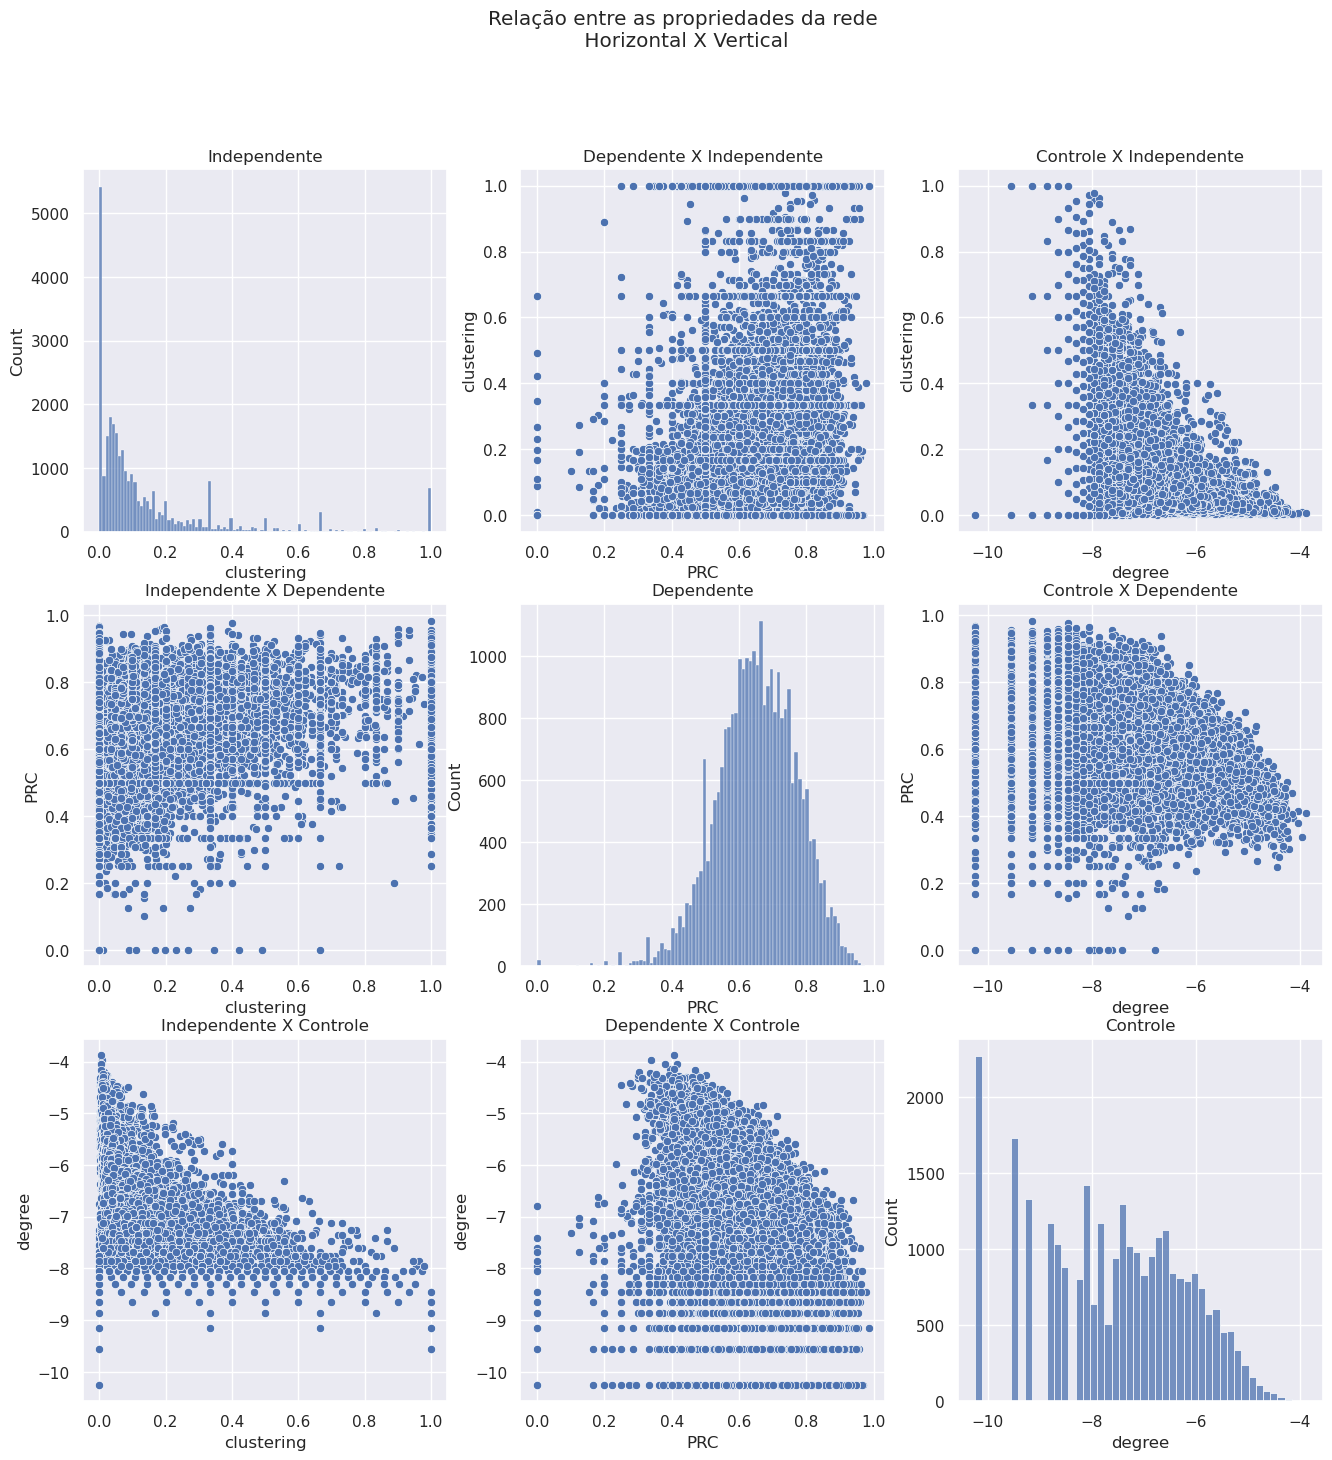

In [39]:
fig, axes = plt.subplots(3, 3, figsize=(16, 16))

fig.suptitle("Relação entre as propriedades da rede\n Horizontal X Vertical")

sns.histplot(independente, ax=axes[0, 0]).set_title("Independente")
sns.scatterplot(x=dependente, y=independente, ax=axes[0, 1]).set_title("Dependente X Independente")
sns.scatterplot(x=controle, y=independente, ax=axes[0, 2]).set_title("Controle X Independente")

sns.scatterplot(x=independente, y=dependente, ax=axes[1, 0]).set_title("Independente X Dependente")
sns.histplot(dependente, ax=axes[1, 1]).set_title("Dependente")
sns.scatterplot(x=controle, y=dependente, ax=axes[1, 2]).set_title("Controle X Dependente")

sns.scatterplot(x=independente, y=controle, ax=axes[2, 0]).set_title("Independente X Controle")
sns.scatterplot(x=dependente, y=controle, ax=axes[2, 1]).set_title("Dependente X Controle")
sns.histplot(controle, ax=axes[2, 2]).set_title("Controle")

plt.show()

In [40]:
def pearsonr(x, y, ndigits=10):
    statistic, p_value = scipy.stats.pearsonr(x, y)
    
    asterisk = ''
    statistic = round(statistic, ndigits)
    
    if statistic == 1: 
        asterisk = ' (óbvio)'
    elif p_value < 0.01: 
        asterisk = ' ***'
    elif p_value < 0.05: 
        asterisk = ' **'
    elif p_value < 0.1: 
        asterisk = ' *'
        
    return f'{statistic} {asterisk}'

In [46]:
columns = ['independente', 'dependente', 'controle']
pd.DataFrame([[pearsonr(data_hipotese[j], data_hipotese[i]) for j in columns] for i in columns], columns=columns)

,independente,dependente,controle
0,1.0 (óbvio),0.2039722444 ***,-0.2232390695 ***
1,0.2039722444 ***,1.0 (óbvio),-0.4663424061 ***
2,-0.2232390695 ***,-0.4663424061 ***,1.0 (óbvio)


In [47]:
result = reg.linear(data=data_hipotese, formula='dependente ~ independente + controle') # dependente à esquerda!
result.micro_summary()

variable,coefficient,std error,p-value
independente,0.061502,0.003134,0.000000
controle,-0.036778,0.000445,0.000000


In [43]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             dependente   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     4182.
Date:                Wed, 06 Nov 2024   Prob (F-statistic):               0.00
Time:                        19:23:45   Log-Likelihood:                 23839.
No. Observations:               28328   AIC:                        -4.767e+04
Df Residuals:                   28325   BIC:                        -4.765e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.3648      0.003    108.562      0.000       0.358       0.371
independente     0.0615      0.003     19.624      0.000       0.055       0.068
controle        -0.0368      0.000    -82.690      0.000      -0.038      -0.036
==============================================================================
Omnibus:                     5199.511   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14575.689
Skew:                          -0.980   Prob(JB):                         0.00
Kurtosis:                       5.916   Cond. No.                         43.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

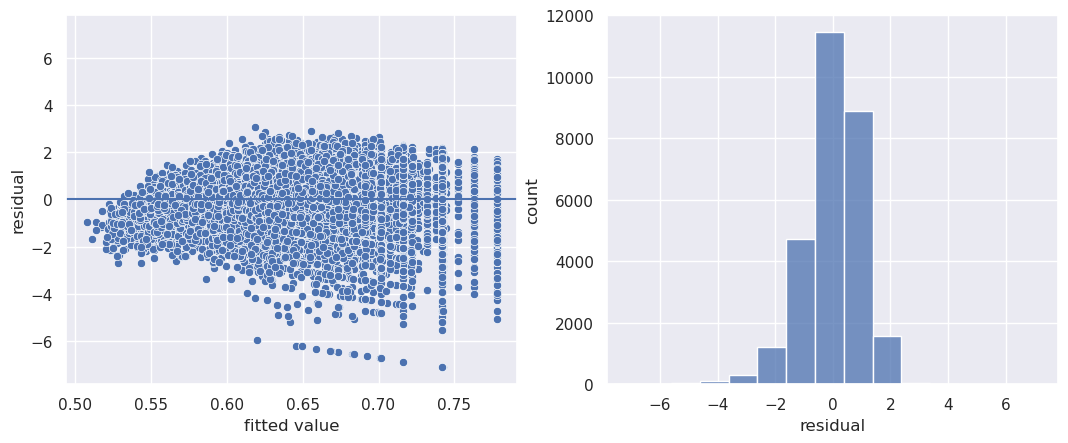

In [44]:
result.plot_residuals()

In [45]:
import os
if not os.path.isdir('img'):
    os.mkdir('img')

sns.histplot(independente).get_figure().savefig('./img/hist_independente.png')
plt.close()
sns.scatterplot(x=dependente, y=independente).get_figure().savefig('./img/dependente_independente.png')
plt.close()
sns.scatterplot(x=controle, y=independente).get_figure().savefig('./img/controle_independente.png')
plt.close()

sns.scatterplot(x=independente, y=dependente).get_figure().savefig('./img/independente_dependente.png')
plt.close()
sns.histplot(dependente).get_figure().savefig('./img/hist_dependente.png')
plt.close()
sns.scatterplot(x=controle, y=dependente).get_figure().savefig('./img/controle_dependente.png')
plt.close()

sns.scatterplot(x=independente, y=controle).get_figure().savefig('./img/independente_controle.png')
plt.close()
sns.scatterplot(x=dependente, y=controle).get_figure().savefig('./img/dependente_controle.png')
plt.close()
sns.histplot(controle).get_figure().savefig('./img/hist_controle.png')
plt.close()